# Customer churn

Customers began to leave Beta-Bank. Every month. A little, but noticeable. Banking marketers figured out it was cheaper to keep current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. We are provided with historical data on customer behavior and termination of agreements with the bank.

It's necessary to build a model with an extremely large *F1*-measure. It's required to bring the metric to 0.59.

*AUC-ROC* should be measured and  compared  with *F1*-measure.

Data Source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

The research will take place in four stages:

1. Data preparation
2. Problem research
3. Dealing with imbalance 
4. Model testing

## Data overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except: 
    df = pd.read_csv('Churn.csv')

In [3]:
def info(df):
    df.info()
    print(100*'=')
    display(df.describe())
    print(100*'=')
    display(df.head())
    print(100*'=')
    display(df.shape)
    print(100*'=')
    print(f'Number of null values: {df.isna().mean()}')
    print(100*'=')
    print(f'Number of duplicates: {df.duplicated().sum()}')
    
info(df) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


(10000, 14)

Number of null values: RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64
Number of duplicates: 0


These columns are not important for our study, so they can be removed.

In [4]:
df.drop(['RowNumber','Surname', 'CustomerId'], axis = 'columns', inplace =True)

There are missing values in the `Tenure` column, they can be replacedwith 0, and  the data type should be changed to `int`.

In [5]:
df['Tenure']=df['Tenure'].fillna(0).astype('int64')

In [6]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


(10000, 11)

Each object in the dataset is information about a customer. It is known:



`RowNumber` - row index in the data

`CustomerId` - unique customer ID

`Surname` - surname

`CreditScore` — credit score

`Geography` - country of residence

`Gender` - gender

`Age` - age

`Tenure` - how many years a person has been a client of the bank

`Balance` — account balance

`NumOfProducts` - the number of bank products used by the client

`HasCrCard` - the presence of a credit card

`IsActiveMember` - client activity

`EstimatedSalary` — estimated salary

**Target feature**

`Exited` - the fact that the client left

- During data preprocessing, missing values in the `Tenure` column were replaced.

- The `RowNumber`, `Surname`, `CustomerId` columns do not provide important information for us, so they can be removed.

Now we can move on to problem research and machine learning.

## Problem research

### Getting rid of categorical features using the OHE method

In [7]:
df_ohe = pd.get_dummies(df, drop_first = True)

In [8]:
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

In [9]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.4, 
                                                                            random_state=12345,
                                                                            stratify=target
                                                                           ) 

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test, 
                                                                            target_test, 
                                                                            test_size=0.5, 
                                                                            random_state=12345,
                                                                            stratify=target_test
                                                                           ) 

In [11]:
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember']

In [12]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

In [13]:
features_train.shape

(6000, 11)

In [14]:
features_valid.shape

(2000, 11)

In [15]:
features_test.shape

(2000, 11)

### Learning with a Decision Tree Model

In [16]:
%%time
best_model_tree = None
best_result_tree = 0
for depth in range(1, 6):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth= depth) 
    model_tree.fit(features_train, target_train)
    predictions = model_tree.predict(features_valid) 
    result_tree = accuracy_score(target_valid, predictions) 
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree


print('Accuracy of the best decision tree model:', best_result_tree)
print("F1:", f1_score(target_valid, predictions))    

Accuracy of the best decision tree model: 0.8575
F1: 0.5454545454545455
CPU times: total: 125 ms
Wall time: 138 ms


In [17]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))

0.5047169811320754


### Machine learning with Random Forest

In [18]:
for depth in range(1,10,1):
    model_forest = RandomForestClassifier(max_depth=depth,random_state=1234)
    model_forest.fit(features_train,target_train)
    prediction=model_forest.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.2096069868995633
max_depth: 3 F1: 0.2755741127348643
max_depth: 4 F1: 0.45255474452554745
max_depth: 5 F1: 0.5442622950819672
max_depth: 6 F1: 0.573228346456693
max_depth: 7 F1: 0.5709728867623605
max_depth: 8 F1: 0.5723172628304822
max_depth: 9 F1: 0.5696594427244581


### Machine learning with Logistic Regression

In [19]:
for depth in range(1,10,1):
    model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
    model_lr.fit(features_train,target_train)
    prediction=model_lr.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.5235602094240838
max_depth: 2 F1: 0.5235602094240838
max_depth: 3 F1: 0.5235602094240838
max_depth: 4 F1: 0.5235602094240838
max_depth: 5 F1: 0.5235602094240838
max_depth: 6 F1: 0.5235602094240838
max_depth: 7 F1: 0.5235602094240838
max_depth: 8 F1: 0.5235602094240838
max_depth: 9 F1: 0.5235602094240838


During the study of models, it was found that `accuracy` is best for Random Forest. The F1 index for Random Forest model and Decision Tree is the same, it is 0.5691609977324262.

## Dealing with imbalance

### Upsampling

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5047169811320754


In [22]:
for depth in range(1,10,1):
    model_up_forest = RandomForestClassifier(max_depth=depth,random_state=1234)
    model_up_forest.fit(features_upsampled,target_upsampled)
    prediction=model_up_forest.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.46921797004991683
max_depth: 2 F1: 0.5982256020278834
max_depth: 3 F1: 0.6009615384615385
max_depth: 4 F1: 0.6105263157894737
max_depth: 5 F1: 0.621867881548975
max_depth: 6 F1: 0.6329113924050633
max_depth: 7 F1: 0.6347031963470321
max_depth: 8 F1: 0.6427745664739885
max_depth: 9 F1: 0.6397146254458977


### Downsampling

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5047169811320754


In [ ]:
for depth in range(1,10,1):
    model__down_forest = RandomForestClassifier(max_depth=depth,random_state=1234)
    model_down_forest.fit(features_downsampled,target_downsampled)
    prediction=model_down_forest.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

When the imbalance was eliminated, the value of F1 increased.

## Model testing

In [22]:
model_up_tree = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model_up_tree.fit(features_upsampled, target_upsampled)
predicted_valid = model_up_tree.predict(features_valid)
print('Accuracy of upsampled Decision Tree model :', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))

Accuracy of upsampled Decision Tree model : 0.8155
F1 0.6019417475728155


In [24]:
model_down_tree = DecisionTreeClassifier(random_state=20052020, max_depth=7)
model_down_tree.fit(features_downsampled, target_downsampled)
predicted_valid = model_down_tree.predict(features_valid)
print('Accuracy of downsampled Decision Tree model:', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))

Accuracy of downsampled Decision Tree model: 0.7915
F1 0.5867195242814668


In [24]:
model_up_forest = RandomForestClassifier(random_state=20052020, n_estimators=53)
model_up_forest.fit(features_upsampled, target_upsampled)
predicted_valid = model_up_forest.predict(features_valid)
print('Accuracy of upsampled Random Forest model', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))

Accuracy of upsampled Random Forest model 0.853
F1 0.6131578947368422


In [25]:
model_down_forest = RandomForestClassifier(random_state=20052020, n_estimators=53)
model_down_forest.fit(features_downsampled, target_downsampled)
predicted_valid = model_down_forest.predict(features_valid)
print('Accuracy downsampled Random Forest', accuracy_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))

Accuracy downsampled Random Forest 0.8095
F1 0.6131979695431472


In [26]:
probabilities_tree=model_tree.predict_proba(features_valid)
probabilities_one_valid_tree=probabilities_tree[:,1]
fpr_tree,tpr_tree,thresholds=roc_curve(target_valid,probabilities_one_valid_tree)
auc_roc_forest=roc_auc_score(target_valid,probabilities_one_valid_tree)
print('AUC-ROC of Decision Tree model:',auc_roc_forest)

AUC-ROC of Decision Tree model: 0.849793544930535


In [27]:
probabilities_forest=model_forest.predict_proba(features_valid)
probabilities_one_valid_forest=probabilities_forest[:,1]
fpr_forest,tpr_forest,thresholds=roc_curve(target_valid,probabilities_one_valid_tree)
auc_roc_forest=roc_auc_score(target_valid,probabilities_one_valid_forest)
print('AUC-ROC of Random Forest model:',auc_roc_forest)

AUC-ROC of Random Forest model: 0.874244075771012


In [28]:
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_one_valid_forest)
fpr_tree, tpr_tree, thresholds = roc_curve(target_valid, probabilities_one_valid_tree)

<Figure size 432x288 with 0 Axes>

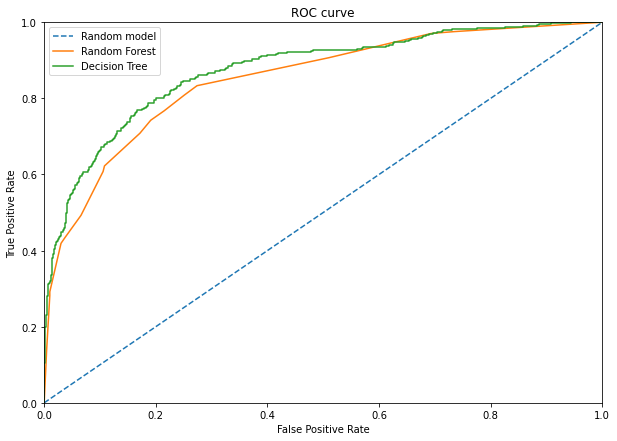

In [29]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(('Random model','Random Forest','Decision Tree'),
           loc= 'upper left') 
plt.show()

It can be concluded that the best value of the metric AUC-ROC =0.847 for the random forest model, accuracy and F1 for the decision tree model.


## Summary

- The data was studied, the data was divided into training, validation and test sets.
- Decision tree, random forest and logical regression models were studied.
- We changed the balance of the sample and checked the testing of the new model.
- We got the `AUC-ROC` of the random forest model: 0.8590747856931717 and F1 0.6173800259403373.